In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    PolynomialFeatures
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    SGDRegressor
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold


In [2]:
train = pd.read_csv('train_sample.csv')
test = pd.read_csv('test_sample.csv')

In [3]:
train.head()

,start_point,end_point,time_of_day,day_of_week,traffic_condition,event_count,is_holiday,vehicle_density,population_density,weather,public_transport_availability,historical_delay_factor,travel_time
0,West Jakarta (Jakarta Barat),South Jakarta (Jakarta Selatan),day,Sunday,NaN,9,1,NaN,high,NaN,1,0.878909,26.907612
1,West Jakarta (Jakarta Barat),South Jakarta (Jakarta Selatan),morning,Thursday,NaN,7,1,medium,high,NaN,1,1.081668,27.489129
2,Central Jakarta (Jakarta Pusat),East Jakarta (Jakarta Timur),morning,Thursday,NaN,7,0,medium,low,NaN,2,1.192379,27.228978
3,West Jakarta (Jakarta Barat),South Jakarta (Jakarta Selatan),morning,Friday,10.0,9,0,medium,high,fog,1,0.833348,33.943970
4,Central Jakarta (Jakarta Pusat),West Jakarta (Jakarta Barat),day,Tuesday,NaN,7,0,medium,high,rain,2,0.966819,20.603115


In [4]:
test.head()

,start_point,end_point,time_of_day,day_of_week,traffic_condition,event_count,is_holiday,vehicle_density,population_density,weather,public_transport_availability,historical_delay_factor
0,West Jakarta (Jakarta Barat),East Jakarta (Jakarta Timur),morning,Saturday,5.0,8,1,medium,NaN,NaN,2,1.126429
1,South Jakarta (Jakarta Selatan),East Jakarta (Jakarta Timur),evening,Saturday,NaN,9,1,low,medium,fog,2,1.121015
2,Central Jakarta (Jakarta Pusat),South Jakarta (Jakarta Selatan),morning,Friday,9.0,8,0,high,NaN,rain,1,1.109638
3,West Jakarta (Jakarta Barat),South Jakarta (Jakarta Selatan),night,Wednesday,5.0,8,1,low,NaN,storm,1,0.842474
4,Central Jakarta (Jakarta Pusat),North Jakarta (Jakarta Utara),morning,Tuesday,NaN,9,1,high,NaN,rain,2,0.775742


In [5]:
print('Train:', train.shape)
print('Test:', test.shape)
print('Data Type')
print(train.dtypes)

Train: (40000, 13)
Test: (3000, 12)
Data Type
start_point                       object
end_point                         object
time_of_day                       object
day_of_week                       object
traffic_condition                float64
event_count                        int64
is_holiday                         int64
vehicle_density                   object
population_density                object
weather                           object
public_transport_availability      int64
historical_delay_factor          float64
travel_time                      float64
dtype: object


In [6]:
print('Missing Value Train')
print(train.isnull().sum())

print('Missing Value Test')
print(test.isnull().sum())

Missing Value Train
start_point                          0
end_point                            0
time_of_day                          0
day_of_week                          0
traffic_condition                14401
event_count                          0
is_holiday                           0
vehicle_density                  14378
population_density               14448
weather                          14429
public_transport_availability        0
historical_delay_factor              0
travel_time                          0
dtype: int64
Missing Value Test
start_point                        0
end_point                          0
time_of_day                        0
day_of_week                        0
traffic_condition                600
event_count                        0
is_holiday                         0
vehicle_density                  600
population_density               600
weather                          600
public_transport_availability      0
historical_delay_factor           

In [7]:
print('Statistik')
print(train['travel_time'].describe())

Statistik
count    40000.000000
mean        30.405411
std         15.074854
min          2.490207
25%         18.685606
50%         26.604213
75%         39.771383
max        218.832465
Name: travel_time, dtype: float64


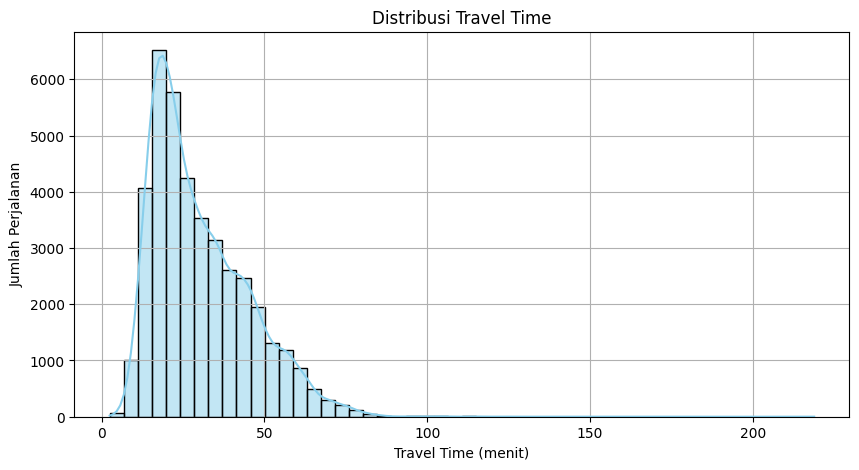

In [8]:
plt.figure(figsize=(10, 5))
sns.histplot(train['travel_time'], bins=50, kde=True, color='skyblue')
plt.title('Distribusi Travel Time')
plt.xlabel('Travel Time (menit)')
plt.ylabel('Jumlah Perjalanan')
plt.grid(True)
plt.show()

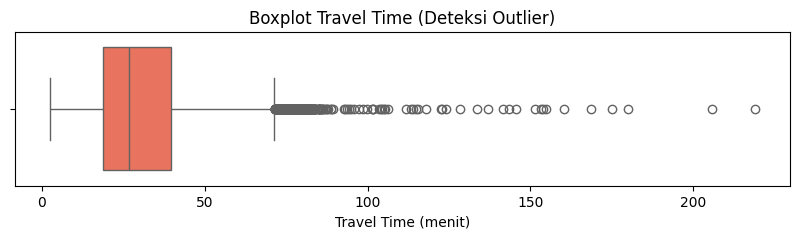

In [9]:
plt.figure(figsize=(10, 2))
sns.boxplot(x=train['travel_time'], color='tomato')
plt.title('Boxplot Travel Time (Deteksi Outlier)')
plt.xlabel('Travel Time (menit)')
plt.show()

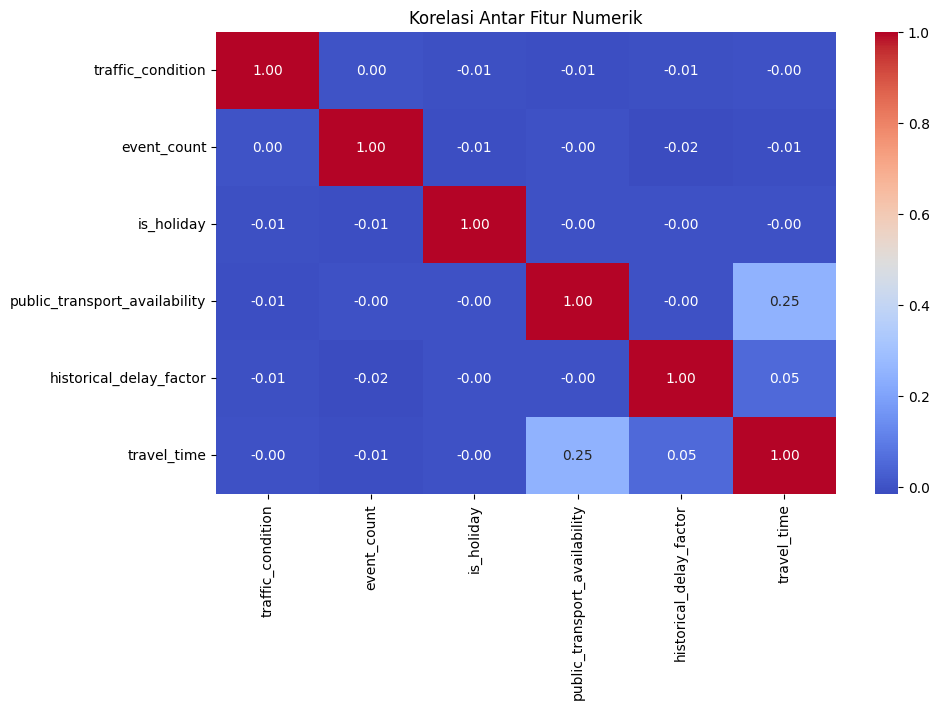

In [10]:
numeric_cols = ['traffic_condition', 'event_count', 'is_holiday', 
                'public_transport_availability', 'historical_delay_factor', 'travel_time']

train[numeric_cols] = train[numeric_cols].apply(pd.to_numeric, errors='coerce')

corr = train[numeric_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi Antar Fitur Numerik')
plt.show()

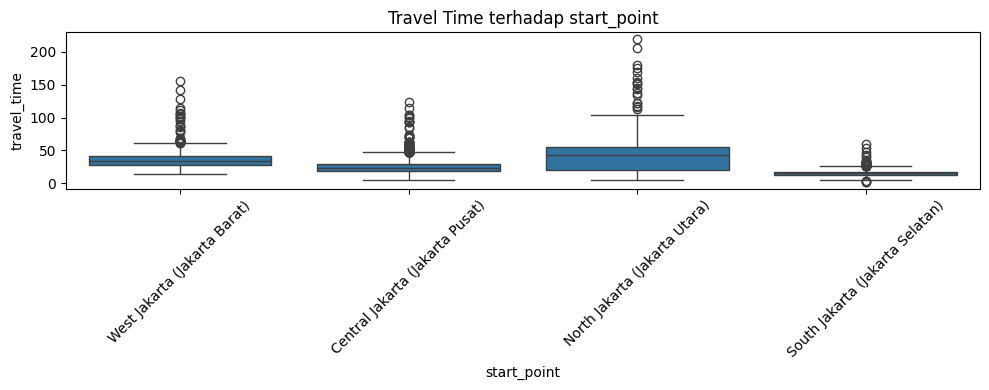

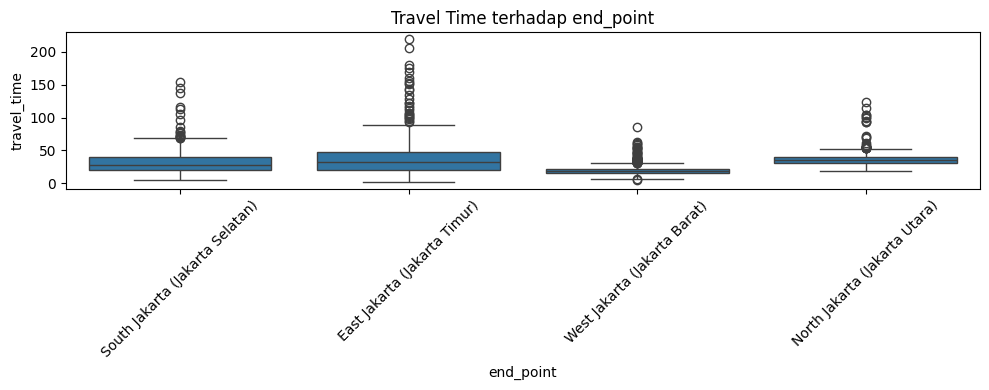

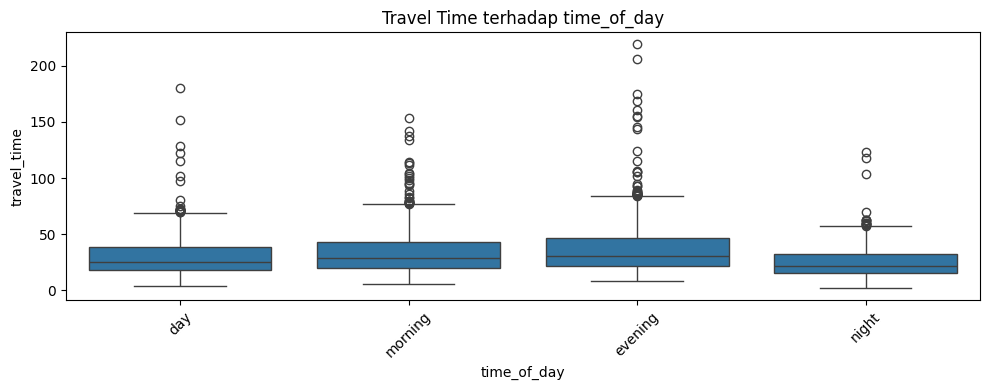

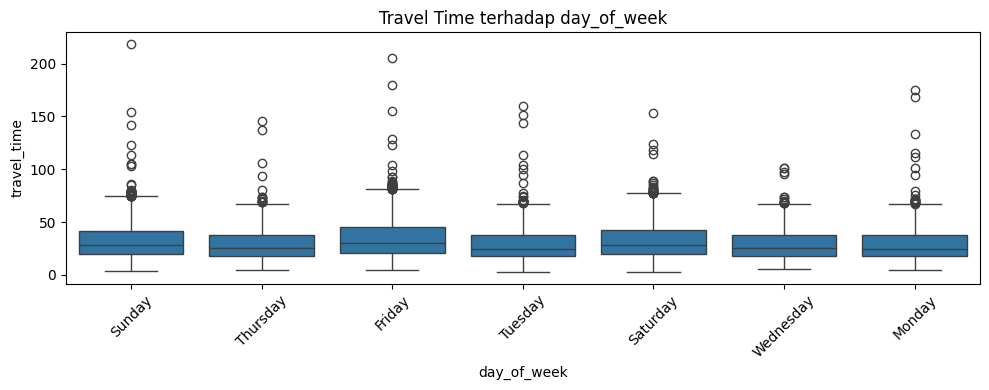

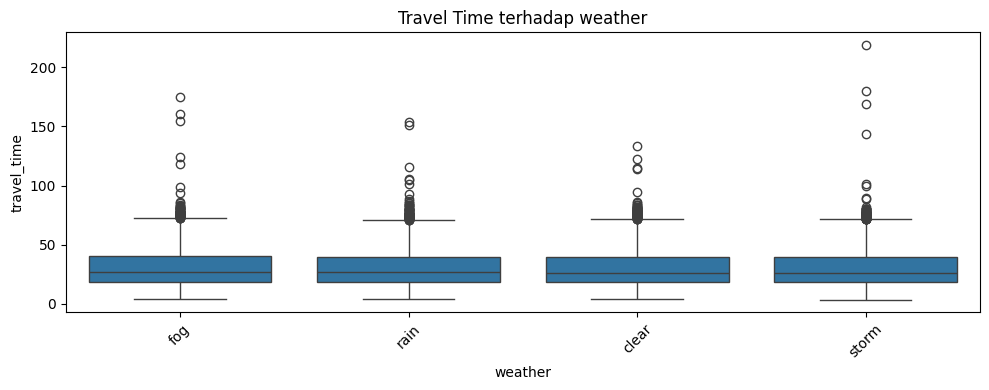

In [11]:
cat_cols = ['start_point', 'end_point', 'time_of_day', 'day_of_week', 'weather']

for col in cat_cols:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=train, x=col, y='travel_time')
    plt.xticks(rotation=45)
    plt.title(f"Travel Time terhadap {col}")
    plt.tight_layout()
    plt.show()

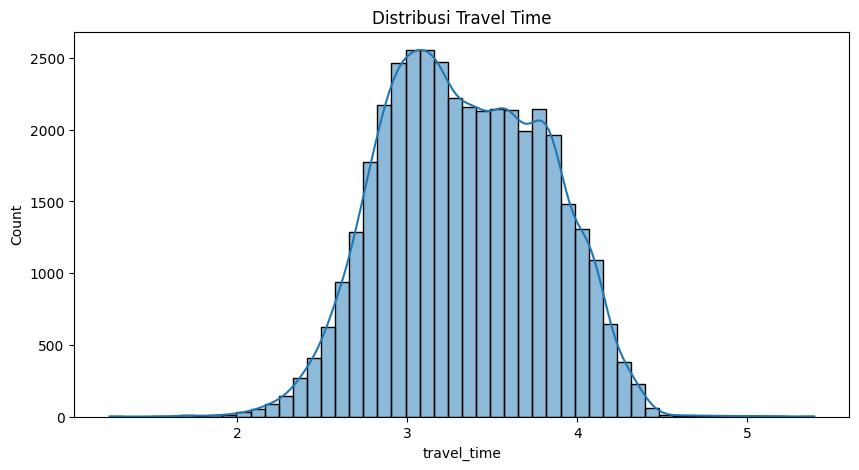

In [12]:
plt.figure(figsize=(10,5))
sns.histplot(np.log1p(train['travel_time']), bins=50, kde=True)
plt.title('Distribusi Travel Time')
plt.show()


<h1>Fitur Engineering</h1>

In [13]:
train['route'] = train['start_point'] + ' - ' + train['end_point']
test['route'] = test['start_point'] + ' - ' + test['end_point']

train['day_time'] = train['day_of_week'] + ' ' + train['time_of_day']
test['day_time'] = test['day_of_week'] + ' ' + test['time_of_day']

train['route_day_time'] = train['route'] + ' - ' + train['day_time']
test['route_day_time'] = test['route'] + ' - ' + test['day_time']

drop_cols = ['start_point','end_point','time_of_day','day_of_week']
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)

In [14]:
for df in [train, test]:
    df['traffic_condition'] = df['traffic_condition'].fillna(df['traffic_condition'].median())
    df['vehicle_density'] = df['vehicle_density'].fillna('unknown')
    df['population_density'] = df['population_density'].fillna('unknown')
    df['historical_delay_factor'] = df['historical_delay_factor'].fillna(df['historical_delay_factor'].median())

In [15]:
train['interaction_traffic_delay'] = train['traffic_condition'] * train['historical_delay_factor']
test['interaction_traffic_delay'] = test['traffic_condition'] * test['historical_delay_factor']

train['interaction_event_holiday'] = train['event_count'] * train['is_holiday']
test['interaction_event_holiday'] = test['event_count'] * test['is_holiday']

for col in ['route','day_time','vehicle_density','population_density','weather']:
    train[f'{col}_traffic'] = train['traffic_condition'] * train.groupby(col)['traffic_condition'].transform('mean')
    test[f'{col}_traffic'] = test['traffic_condition'] * test.groupby(col)['traffic_condition'].transform('mean')

train['weather_traffic'] = train['weather'].astype(str) + '_' + train['traffic_condition'].astype(str)
test['weather_traffic'] = test['weather'].astype(str) + '_' + test['traffic_condition'].astype(str)

vd_map = {'low':1, 'medium':2, 'high':3, 'unknown':0}
pd_map = {'low':1, 'medium':2, 'high':3, 'unknown':0}

train['vd_numeric'] = train['vehicle_density'].map(vd_map)
test['vd_numeric'] = test['vehicle_density'].map(vd_map)

train['pd_numeric'] = train['population_density'].map(pd_map)
test['pd_numeric'] = test['population_density'].map(pd_map)

train['interaction_density'] = train['vd_numeric'] * train['pd_numeric']
test['interaction_density'] = test['vd_numeric'] * test['pd_numeric']

train.drop(['vd_numeric','pd_numeric'], axis=1, inplace=True)
test.drop(['vd_numeric','pd_numeric'], axis=1, inplace=True)

for col in ['route','day_time']:
    freq = train[col].value_counts(normalize=True)
    train[f'{col}_freq'] = train[col].map(freq)
    test[f'{col}_freq'] = test[col].map(freq).fillna(0)

route_day_time_mean = train.groupby('route_day_time')['travel_time'].mean()
train['route_day_time_mean'] = train['route_day_time'].map(route_day_time_mean)
test['route_day_time_mean'] = test['route_day_time'].map(route_day_time_mean).fillna(train['travel_time'].mean())

In [16]:
important_numericals = ['traffic_condition', 'historical_delay_factor', 'event_count']
poly2_numericals = ['interaction_traffic_delay', 'interaction_event_holiday']

numerical_cols = ['traffic_condition', 'event_count', 'is_holiday', 'public_transport_availability',
                  'historical_delay_factor', 'interaction_traffic_delay', 'interaction_event_holiday', 'interaction_density',
                  'route_day_time_mean'] + \
                 [f'{col}_traffic' for col in ['route','day_time','vehicle_density','population_density','weather']] + \
                 [f'{col}_freq' for col in ['route','day_time']]

numerical_cols = [col for col in numerical_cols if train[col].dtype in ['int64','float64']]

all_features = set(train.columns) - {'travel_time'}
categorical_cols = list(all_features - set(numerical_cols))

<h1>Fix Semoga</h1>

In [17]:
y = train['travel_time']

In [18]:
preprocessor = ColumnTransformer([
    ('important_poly', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('poly', PolynomialFeatures(degree=4, include_bias=False)),
        ('scaler', StandardScaler())
    ]), important_numericals),

    ('poly2', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler())
    ]), poly2_numericals),

    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), list(set(numerical_cols) - set(important_numericals) - set(poly2_numericals))),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols)
])

In [19]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(max_iter=10000))
])

In [20]:
param_grid = {'regressor__alpha': np.linspace(0.5, 3, 15)}
# param_grid = {'regressor__alpha': (0, 1.0357142857142856)} # -> ini yang hasilnya 0.657406026
# lupa random state :(
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(train.drop('travel_time', axis=1), y)

,estimator,Pipeline(step...iter=10000))])
,param_grid,"{'regressor__alpha': array([0.5 ..., 3. ])}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('important_poly', ...), ('poly2', ...), ...]"


In [21]:
print("Best alpha:", grid_search.best_params_)
print("CV R2:", grid_search.best_score_)

Best alpha: {'regressor__alpha': 1.3928571428571428}
CV R2: 0.9151287301927047


In [22]:
y_test_pred = grid_search.predict(test)
y_test_pred = np.clip(y_test_pred, 0, None)

file = pd.DataFrame({'0': y_test_pred})
file.to_csv('submission.csv', index=False)

In [ ]:
# Best alpha: {'regressor__alpha': 1.0357142857142856}
# CV R2: 0.915115217902455
# ini yang hasilnya 0.657406026